# 深层神经网络

In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

from torch import nn
from torch.autograd import Variable

In [3]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

Processing...
Done!


我们可以看看其中的一个数据是什么样子的

In [7]:
a_data, a_label = train_set[0]

In [8]:
a_data

In [9]:
a_label

5

这里的读入的数据是 PIL 库中的格式，我们可以非常方便地将其转换为 numpy array

In [12]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

(28, 28)


这里我们可以看到这种图片的大小是 28 x 28

In [13]:
print(a_data)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

我们可以将数组展示出来，里面的 0 就表示黑色，255 表示白色

对于神经网络，我们第一层的输入就是 28 x 28 = 784，所以必须将得到的数据我们做一个变换，使用 reshape 将他们拉平成一个一维向量

In [2]:
def data_tf(x):
    x = np.array(x, dtype='float32')
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

In [20]:
a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


In [3]:
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

使用这样的数据迭代器是非常有必要的，如果数据量太大，就无法一次将他们全部读入内存，所以需要使用 python 迭代器，每次生成一个批次的数据

In [22]:
a, a_label = next(iter(train_data))

In [24]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [4]:
# 使用 Sequential 定义 4 层神经网络
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [5]:
net

Sequential(
  (0): Linear(in_features=784, out_features=400)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10)
)

交叉熵在 pytorch 中已经内置了，交叉熵的数值稳定性更差，所以内置的函数已经帮我们解决了这个问题

In [6]:
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()
optimzier = torch.optim.SGD(net.parameters(), 1e-3) # 使用随机梯度下降，学习率 0.01

In [7]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimzier.zero_grad()
        loss.backward()
        optimzier.step()
        # 记录误差
        train_loss += loss.data[0]
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().data[0]
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.data[0]
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().data[0]
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.389691, Train Acc: 0.890658, Eval Loss: 0.194884, Eval Acc: 0.942741
epoch: 1, Train Loss: 0.165117, Train Acc: 0.951009, Eval Loss: 0.172241, Eval Acc: 0.947191
epoch: 2, Train Loss: 0.119985, Train Acc: 0.964402, Eval Loss: 0.141385, Eval Acc: 0.956092
epoch: 3, Train Loss: 0.094235, Train Acc: 0.972165, Eval Loss: 0.127563, Eval Acc: 0.961531
epoch: 4, Train Loss: 0.076072, Train Acc: 0.977245, Eval Loss: 0.124801, Eval Acc: 0.961828
epoch: 5, Train Loss: 0.062741, Train Acc: 0.982209, Eval Loss: 0.117944, Eval Acc: 0.965783
epoch: 6, Train Loss: 0.051375, Train Acc: 0.985458, Eval Loss: 0.113207, Eval Acc: 0.964498
epoch: 7, Train Loss: 0.042990, Train Acc: 0.988539, Eval Loss: 0.110351, Eval Acc: 0.967069
epoch: 8, Train Loss: 0.036279, Train Acc: 0.990872, Eval Loss: 0.106079, Eval Acc: 0.968750
epoch: 9, Train Loss: 0.030319, Train Acc: 0.992554, Eval Loss: 0.110177, Eval Acc: 0.967761
epoch: 10, Train Loss: 0.025076, Train Acc: 0.994453, Eval Loss: 0.106

画出 loss 曲线和 准确率曲线

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

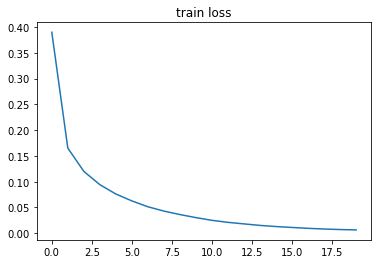

In [9]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

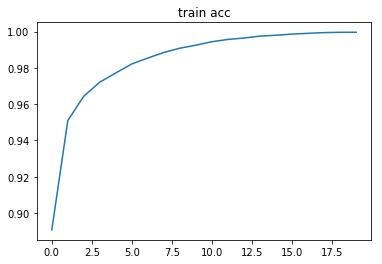

In [10]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

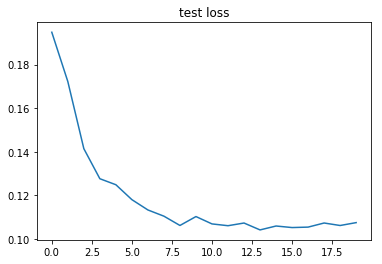

In [11]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

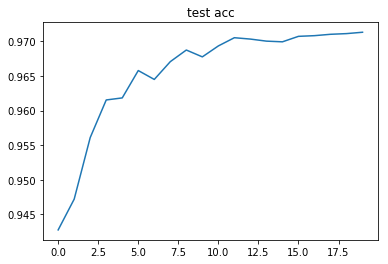

In [12]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')

可以看到我们的三层网络在训练集上能够达到 99.9% 的准确率，测试集上能够达到 97.13% 的准确率